# Air Track

### Date: 13/05/19 - 14/05/19
### Group Members: Aayushi Verma, Diana Kommedal, Alex Goodenbour

## Introduction

## Method

## Analysis

In [37]:
# Setup and helper function definition

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pds
import scipy.optimize

def round_to_1(x):
    return round(x, -int(np.floor(np.log10(abs(x)))))

def model(t, a, b, c):
    #return a + b*np.sin(t) + c*np.cos(t)
    return a + b*np.sin(t) + c*np.cos(t)

def bestfit(x,y,sigma_x, sigma_y):
    n = 3
    bf = np.zeros((n,len(x)))
    bf[0,:] = x**0
    bf[1,:] = np.sin(x)
    bf[2,:] = np.cos(x)


    A = np.zeros((n,n))
    b = np.zeros(n)
    for k in range(n):
        for j in range(n):
            A[k,j] = np.sum(bf[k,:]*bf[j,:]/sigma_y**2) 
        b[k] = np.sum(y*bf[k,:]/sigma_y**2)

    A_inv = np.linalg.inv(A)
    a = np.linalg.solve(A,b)
    a_unc = np.sqrt(np.diag(A_inv))[1]
    return a, a_unc

def pairs_amps(lst):
    if (len(lst)%2)!=0:
        raise Exception("Odd list")
    amps = []
    for i, val in enumerate(lst):
        if (i%2)==0:
            amps.append((lst[i+1]-lst[i])/2)
    return amps


def sinusoid(A, w, phase, t):
    return A*np.sin(w*t+phase)

in_to_cm = lambda x: 2.54*x
w_to_f = lambda w: w/(2*np.pi)

data = pds.read_csv("air_track.csv")

In [59]:
extensions = data.initial - data.final

m = 19.99e-3

m_car = 0.184

cardist = 10e-2

g = 9.81
del_x = extensions.mean()*1e-2

s = (m*g)/del_x

print("Calculated Spring Constant: ", round(s,4), "Nm^-1")
print()

w = lambda m, K, M: 2*np.sqrt(K/M)*np.sin((np.pi*m)/20)

for i in range(9):
    print("f", i+1, ":", round(w_to_f(w(i+1, s, m_car)),4), "Hz")

Calculated Spring Constant:  4.6033 Nm^-1

f 1 : 0.2491 Hz
f 2 : 0.492 Hz
f 3 : 0.7228 Hz
f 4 : 0.9358 Hz
f 5 : 1.1258 Hz
f 6 : 1.2881 Hz
f 7 : 1.4186 Hz
f 8 : 1.5142 Hz
f 9 : 1.5725 Hz


[6.199999999999999, 11.100000000000001, 15.0, 16.900000000000006, 17.050000000000004, 16.200000000000003, 15.900000000000006, 10.399999999999991, 5.849999999999994]
Theoretical Wavelengths:  [2.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.3333333333333333, 0.2857142857142857, 0.25, 0.2222222222222222]


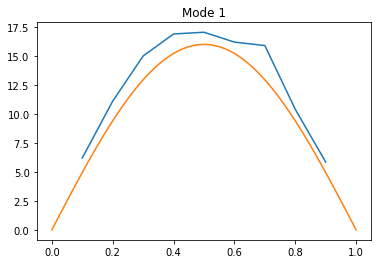

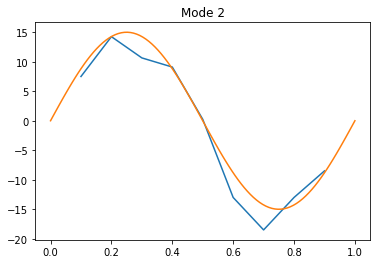

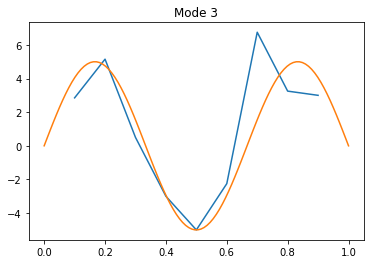

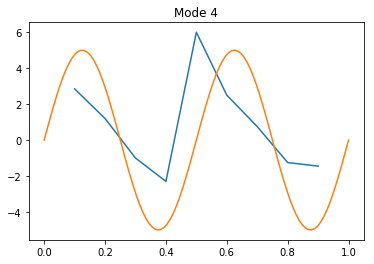

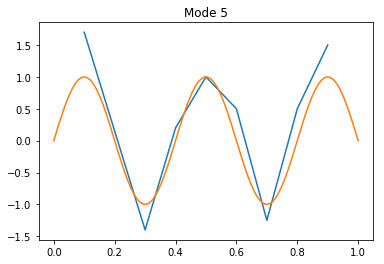

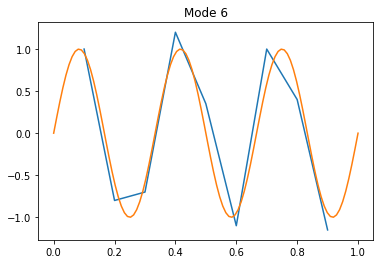

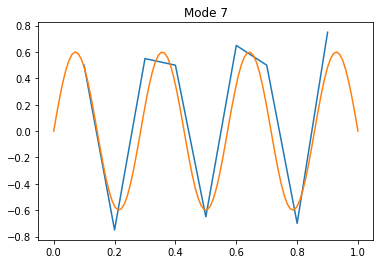

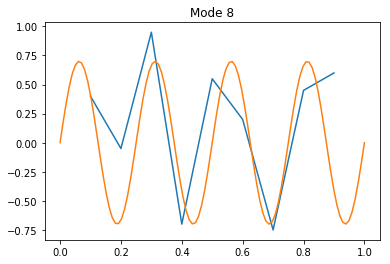

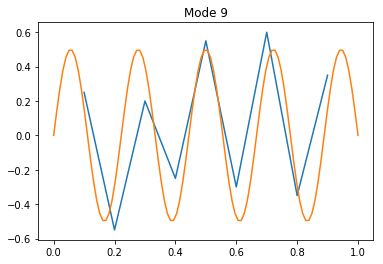

In [55]:
#print(data.M1)
xs = cardist*np.array(range(1,10))
print(pairs_amps(data.M1))

theo_lambdas = [(2*(9+1)*cardist)/m for m in range(1,10)]
sinusoid_amplitudes = [16,15,5,5,1,1,0.6,0.7,0.5]

for i in range(0,9): 
    plt.figure(i+1)
    plt.title("Mode "+str(i+1))
    amps = np.array(pairs_amps(data["M"+str(i+1)]))
    plt.plot(xs,amps)
    a, a_unc = bestfit(xs, amps,0.01, 0.01)
    xx = np.linspace(0,1,100)
    
    ## Plots sine curve according to theoretical standing wave
    plt.plot(xx, sinusoid(sinusoid_amplitudes[i],(2*np.pi)/theo_lambdas[i], 0, xx))

w_to_lambda = lambda w: (2*np.pi)/w

print("Theoretical Wavelengths: ", theo_lambdas)


Text(0.5, 1.0, 'Theoretical Dispersion')

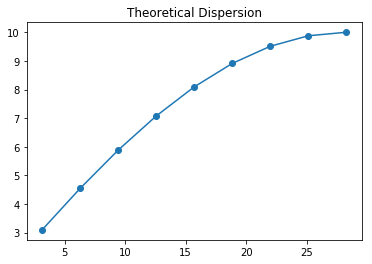

In [68]:
theo_k_m = [(m*np.pi)/(10*cardist) for m in range(1,10)]
ws = [w(i+1, s, m_car) for i in range(1,10)]
#print(theo_k_m)
plt.plot(theo_k_m, ws, marker="o")
plt.title("Theoretical Dispersion")

## Discussion

## Conclusion